# Short Term Risk Prediction With XGBoost

In this notebook we try and predict readmission in general using data created in the Feature Engineering notebook.

In [1]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import scikitplot as skplt
import time
import pickle

os.environ["OMP_NUM_THREADS"] = "8"

TRAIN = True

In [2]:
df = pd.read_csv("Clean_Data_v2.csv")

In [3]:
df.shape

(69879, 120)

In [4]:
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_22,admission_source_id_25
0,0,1,41,0,1,0,0,0,1,NaN,...,0,0,0,0,0,0,0,0,0,0
1,10,3,59,0,18,0,0,0,9,NaN,...,0,1,0,0,0,0,0,0,0,0
2,20,2,11,5,13,2,0,1,6,NaN,...,0,1,0,0,0,0,0,0,0,0
3,30,2,44,1,16,0,0,0,7,NaN,...,0,1,0,0,0,0,0,0,0,0
4,40,1,51,0,8,0,0,0,5,NaN,...,0,1,0,0,0,0,0,0,0,0


# Train Test Split

In [5]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['readmitted']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

Examples in training:

In [6]:
y_train.value_counts()

0    36914
1    12001
Name: readmitted, dtype: int64

Examples in testing:

In [7]:
y_test.value_counts()

0    15821
1     5143
Name: readmitted, dtype: int64

In both cases, the proportion of classes in the same.

In [8]:
scale_pos_weight = y_test.value_counts()[0] / y_test.value_counts()[1]
scale_pos_weight


3.076220104997083

This is our baseline for the scale_pos_weight parameter.

# Dealing With Class Imbalance

## Grid Search For Hyperparameters

Note that we are not using classification error for the evaluation metric because we would get "good" results from just choosing the negative class all the time. Instead, we use the auc curve so we need to perform well on the positive and negative cases.

Given that we are having issues with recall, we will change the scoring parameter to recall as opposed to ROC AUC as well.

In [17]:
model = XGBClassifier(n_jobs=8, scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [3, 6, 8, 12],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'min_child_weight': [1, 3, 5]
}

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
grid_search = GridSearchCV(model, param_grid, scoring="recall", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.629433 using {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}


## Train A Model With Best Hyperparameters

In [18]:
model = XGBClassifier(n_jobs=8, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=scale_pos_weight, min_child_weight=5)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.076220104997083,
              seed=None, silent=None, subsample=1, verbosity=1)

In [19]:
y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 67.74%


## Accuracy

In [20]:
# make predictions for test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.75%


In [21]:
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [22]:
np.sum(y_pred)

8505

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  10655
False Positives:  5166
False Negatives:  1804
True Positives:  3339


In [24]:
def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

precision = compute_precision(tp, fp)
recall = compute_recall(tp, fn)

print('Precision: {0:.2f}\n\nRecall: {1:.2f}'.format(precision, recall))

Precision: 0.39

Recall: 0.65


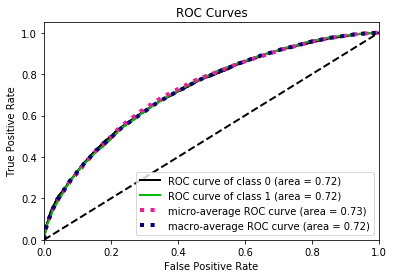

In [25]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()


We finally have a model that has good recall and the AUC is still 0.72 which is around the previous optimum found by other models that had bad recall.

## Serialize model

In [26]:
pickle.dump(model, open("long_term_xgboost_v1.pickle.dat", "wb"))

## Feature Importance

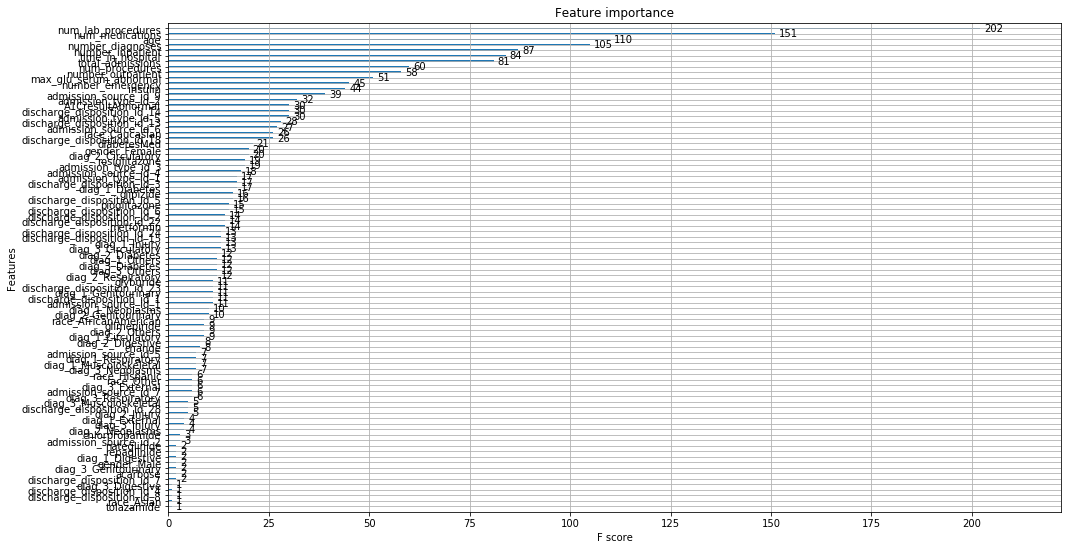

In [27]:
plt.rcParams["figure.figsize"] = [16,9]
plot_importance(model)
plt.show()

There are a lot of features here but we can limit the number of features because it appears that only the top few are important.

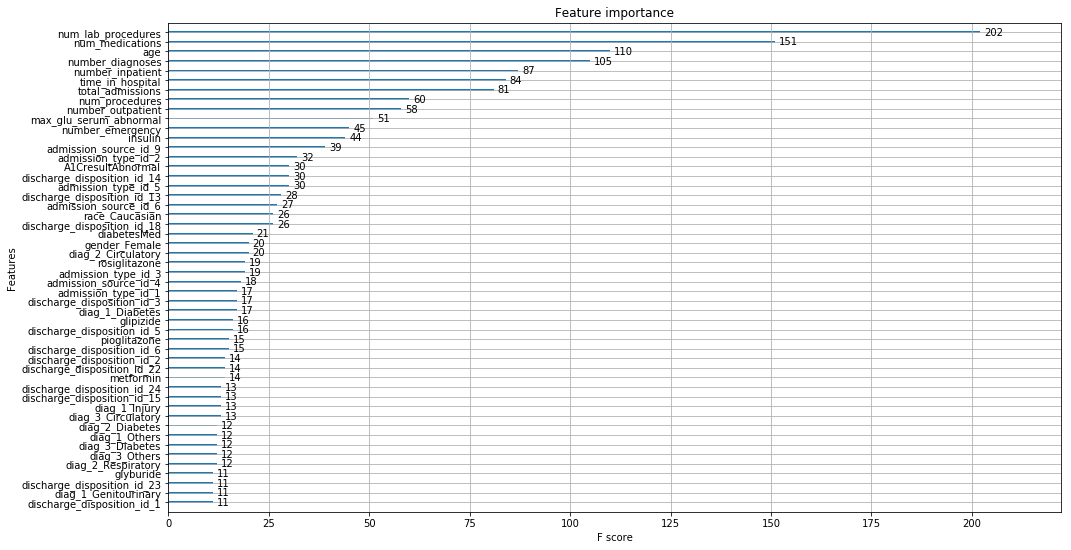

In [28]:
plot_importance(model, max_num_features=50)
plt.show()
